###### 변수선택 기준

* Lag(1) 상관계수 기준 0.1 이상
* 다중공선성 10 미만
* 필요시 필터링을 활용한 추가 feature engieering을 고려할 수 있음

In [112]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (7,5)

In [114]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data

In [115]:
df_ori = pd.read_csv('data/data_EDA.csv')
df_ori['time'] = pd.to_datetime(df_ori['time'])
df_ori = df_ori.set_index('time')

## lag 상관분석

* 모델링에서는 과거의 정보로 현재의 의사결정이 이루어지므로  
  1단위 이전의 정보와 종속변수 간의 상관관계가 변수선택의 중요한 요소가 됨 => 모형의 성능을 좌우할 수 있음

In [116]:
dataset = df_ori[['spread_ratio',
                  'vwap_near', 'vwap_longer', 'volume_near', 'volume_longer', 'duetime',
                  'volume_near_log', 'volume_longer_log', 'vwap_near_rets', 'vwap_longer_rets',
                  'vwap_near_rets_abs', 'vwap_longer_rets_abs']].copy()
dataset = dataset.shift(1).dropna()
dataset['target'] = df_ori['spread'].copy()

In [117]:
lcorr_res = dataset.corr()[['target']]

spread_ratio


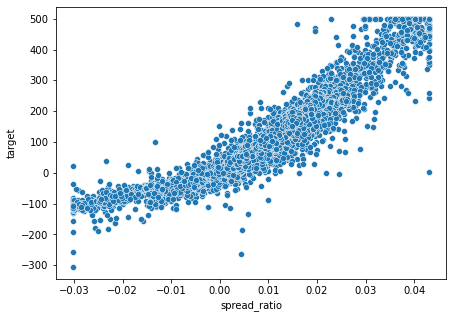

vwap_near


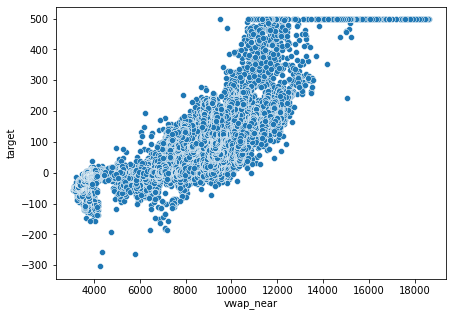

vwap_longer


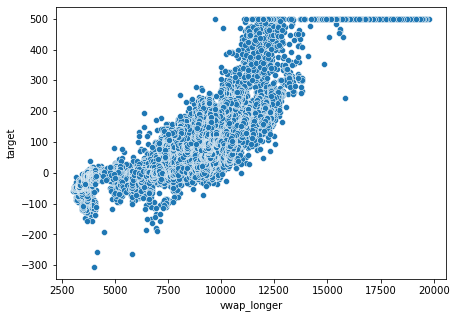

volume_near


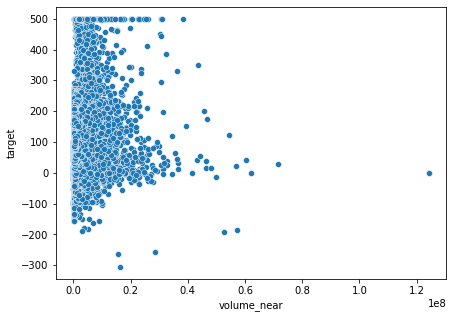

volume_longer


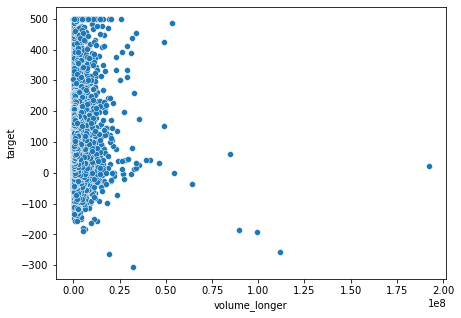

duetime


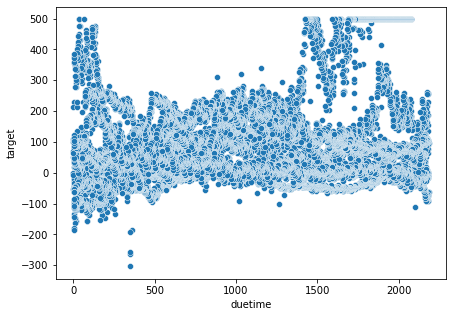

volume_near_log


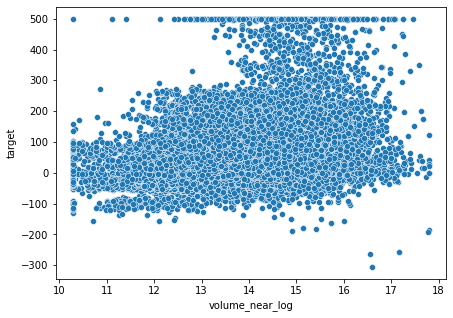

volume_longer_log


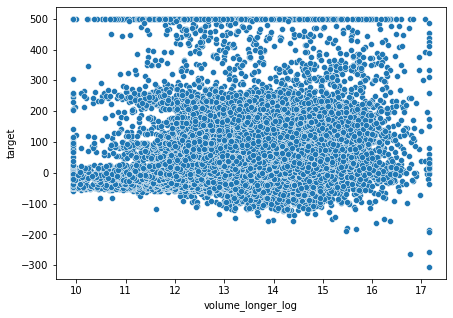

vwap_near_rets


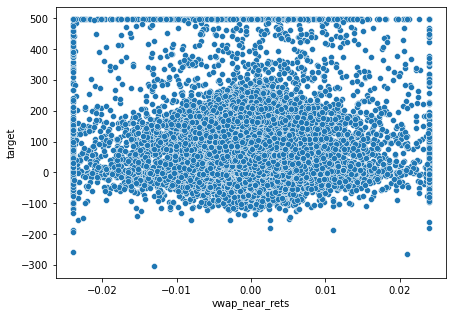

vwap_longer_rets


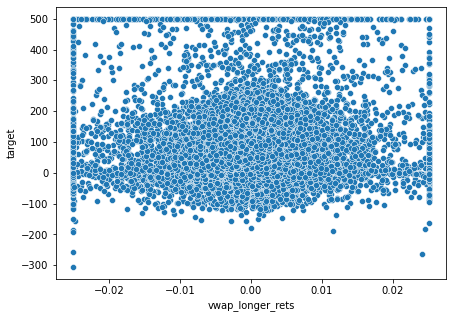

vwap_near_rets_abs


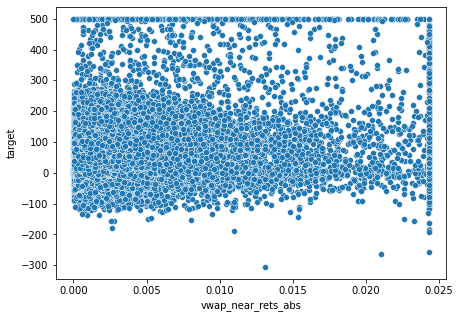

vwap_longer_rets_abs


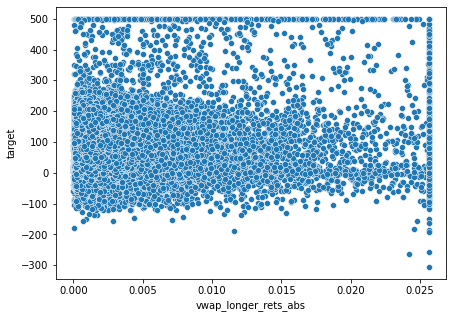

In [118]:
for mac in dataset.columns[:-1]:
    print(mac)
    sns.scatterplot(data = dataset, x=mac, y = 'target')
    plt.show()

In [119]:
## 상관계수 abs(0.1) 이상 변수만 선택함

## 다중공선성

In [120]:
Xs = lcorr_res[(lcorr_res['target'] > 0.1)|(lcorr_res['target'] < -0.1)].index[:-1]

In [121]:
Xs

Index(['spread_ratio', 'vwap_near', 'vwap_longer', 'volume_near',
       'volume_near_log', 'volume_longer_log', 'vwap_near_rets_abs',
       'vwap_longer_rets_abs'],
      dtype='object')

In [122]:
X = dataset[Xs].copy()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,2.735518,volume_near
1,6.847527,spread_ratio
2,13.743416,vwap_longer_rets_abs
3,14.040102,vwap_near_rets_abs
4,255.301274,volume_near_log
5,263.889980,volume_longer_log
6,14944.962675,vwap_near
7,15015.413043,vwap_longer


In [123]:
## 다중공선성이 매우 높음
## 거래량 변수가 서로 상관
## 가격 변수가 sprea_ratio와 상관

In [124]:
X = dataset[['spread_ratio', 'duetime', 'volume_near_log', 'vwap_near_rets_abs']].copy()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.364886,spread_ratio
1,1.870275,vwap_near_rets_abs
2,4.099151,duetime
3,5.313503,volume_near_log


In [125]:
## GRU 활용시에는 임의 lag가 불필요하므로 원시계열로 복구 후 저장
## ML에서는 임의 lag 필요
data_sel = df_ori[['epi_no', 'spread_ratio', 'vwap_near_rets_abs', 'duetime', 'volume_near_log', 'spread']].copy()

## Save

In [126]:
data_sel.to_csv('data/data_featsel.csv')